In [32]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split

# === Load .npy files ===
X_seq = np.load("X_seq.npy")  # shape: (N, 100, 1024)
y_seq = np.load("y_seq.npy")  # shape: (N,)

# === Split into train/test (stratified) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# === Convert to PyTorch tensors ===
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# === Wrap in TensorDataset ===
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# === Split train into train/val ===
val_ratio = 0.1
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# === Build DataLoaders ===
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ DataLoaders ready:")
print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_dataset)}")


✅ DataLoaders ready:
Train: 7727 | Val: 858 | Test: 2147


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YAMNet1DCNN_Improved(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.75)  # Slightly higher for better regularization
        self.fc = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [2]:
%pip install simpleaudio

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import re
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# === Configuration ===
model_class = YAMNet1DCNN_Improved
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Find all saved models matching pattern ===
model_files = [f for f in os.listdir() if f.startswith("Model_") and f.endswith(".pt")]

# Optional: sort by val_acc (e.g., Model_91_88_Epoch58.pt)
def extract_val_acc(file):
    match = re.search(r'Model_(\d+)_(\d+)', file)
    if match:
        major, minor = match.groups()
        return float(f"{major}.{minor}")
    return 0.0

model_files.sort(key=extract_val_acc, reverse=True)

# === Evaluate each model ===
results = []

for model_file in model_files:
    print(f"\n🔍 Evaluating {model_file}")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc=f"Testing {model_file}", leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            preds = preds.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    results.append((model_file, acc))

# === Print sorted results ===
results.sort(key=lambda x: x[1], reverse=True)

print("\n📊 Model Comparison Results:")
for name, acc in results:
    print(f"{name:<35} → Test Accuracy: {acc:.2f}%")



🔍 Evaluating Model_93_12_Epoch138.pt



🔍 Evaluating Model_93_12_Epoch147.pt



🔍 Evaluating Model_92_89_Epoch137.pt



🔍 Evaluating Model_92_89_Epoch139.pt



🔍 Evaluating Model_92_89_Epoch145.pt



🔍 Evaluating Model_92_89_Epoch177.pt



🔍 Evaluating Model_92_89_Epoch198.pt



🔍 Evaluating Model_92_89_Epoch93.pt



🔍 Evaluating Model_92_77_Epoch113.pt



🔍 Evaluating Model_92_77_Epoch124.pt



🔍 Evaluating Model_92_77_Epoch136.pt



🔍 Evaluating Model_92_77_Epoch146.pt



🔍 Evaluating Model_92_77_Epoch154.pt



🔍 Evaluating Model_92_77_Epoch155.pt



🔍 Evaluating Model_92_77_Epoch156.pt



🔍 Evaluating Model_92_77_Epoch159.pt



🔍 Evaluating Model_92_77_Epoch162.pt



🔍 Evaluating Model_92_77_Epoch163.pt



🔍 Evaluating Model_92_77_Epoch164.pt



🔍 Evaluating Model_92_77_Epoch170.pt



🔍 Evaluating Model_92_77_Epoch172.pt



🔍 Evaluating Model_92_77_Epoch173.pt



🔍 Evaluating Model_92_77_Epoch180.pt



🔍 Evaluating Model_92_77_Epoch186.pt



🔍 Evaluating Model_92_77_Epoch188.pt



🔍 Evaluating Model_92_77_Epoch189.pt



🔍 Evaluating Model_92_77_Epoch191.pt



🔍 Evaluating Model_92_77_Epoch192.pt



🔍 Evaluating Model_92_77_Epoch193.pt



🔍 Evaluating Model_92_77_Epoch194.pt



🔍 Evaluating Model_92_77_Epoch195.pt



🔍 Evaluating Model_92_77_Epoch196.pt



🔍 Evaluating Model_92_77_Epoch197.pt



🔍 Evaluating Model_92_77_Epoch200.pt



🔍 Evaluating Model_92_77_Epoch64.pt



🔍 Evaluating Model_92_66_Epoch120.pt



🔍 Evaluating Model_92_66_Epoch123.pt



🔍 Evaluating Model_92_66_Epoch126.pt



🔍 Evaluating Model_92_66_Epoch131.pt



🔍 Evaluating Model_92_66_Epoch135.pt



🔍 Evaluating Model_92_66_Epoch140.pt



🔍 Evaluating Model_92_66_Epoch143.pt



🔍 Evaluating Model_92_66_Epoch144.pt



🔍 Evaluating Model_92_66_Epoch153.pt



🔍 Evaluating Model_92_66_Epoch157.pt



🔍 Evaluating Model_92_66_Epoch158.pt



🔍 Evaluating Model_92_66_Epoch160.pt



🔍 Evaluating Model_92_66_Epoch165.pt



🔍 Evaluating Model_92_66_Epoch166.pt



🔍 Evaluating Model_92_66_Epoch167.pt



🔍 Evaluating Model_92_66_Epoch169.pt



🔍 Evaluating Model_92_66_Epoch175.pt



🔍 Evaluating Model_92_66_Epoch178.pt



🔍 Evaluating Model_92_66_Epoch183.pt



🔍 Evaluating Model_92_66_Epoch184.pt



🔍 Evaluating Model_92_66_Epoch185.pt



🔍 Evaluating Model_92_66_Epoch187.pt



🔍 Evaluating Model_92_66_Epoch190.pt



🔍 Evaluating Model_92_66_Epoch199.pt



🔍 Evaluating Model_92_66_Epoch94.pt



🔍 Evaluating Model_92_54_Epoch111.pt



🔍 Evaluating Model_92_54_Epoch118.pt



🔍 Evaluating Model_92_54_Epoch125.pt



🔍 Evaluating Model_92_54_Epoch129.pt



🔍 Evaluating Model_92_54_Epoch132.pt



🔍 Evaluating Model_92_54_Epoch148.pt



🔍 Evaluating Model_92_54_Epoch149.pt



🔍 Evaluating Model_92_54_Epoch152.pt



🔍 Evaluating Model_92_54_Epoch168.pt



🔍 Evaluating Model_92_54_Epoch171.pt



🔍 Evaluating Model_92_54_Epoch174.pt



🔍 Evaluating Model_92_54_Epoch176.pt



🔍 Evaluating Model_92_54_Epoch181.pt



🔍 Evaluating Model_92_54_Epoch182.pt



🔍 Evaluating Model_92_54_Epoch61.pt



🔍 Evaluating Model_92_54_Epoch63.pt



🔍 Evaluating Model_92_54_Epoch92.pt



🔍 Evaluating Model_92_54_Epoch97.pt



🔍 Evaluating Model_92_42_Epoch103.pt



🔍 Evaluating Model_92_42_Epoch108.pt



🔍 Evaluating Model_92_42_Epoch110.pt



🔍 Evaluating Model_92_42_Epoch115.pt



🔍 Evaluating Model_92_42_Epoch116.pt



🔍 Evaluating Model_92_42_Epoch119.pt



🔍 Evaluating Model_92_42_Epoch130.pt



🔍 Evaluating Model_92_42_Epoch133.pt



🔍 Evaluating Model_92_42_Epoch134.pt



🔍 Evaluating Model_92_42_Epoch141.pt



🔍 Evaluating Model_92_42_Epoch142.pt



🔍 Evaluating Model_92_42_Epoch150.pt



🔍 Evaluating Model_92_42_Epoch161.pt



🔍 Evaluating Model_92_42_Epoch179.pt



🔍 Evaluating Model_92_42_Epoch98.pt



🔍 Evaluating Model_92_31_Epoch104.pt



🔍 Evaluating Model_92_31_Epoch109.pt



🔍 Evaluating Model_92_31_Epoch114.pt



🔍 Evaluating Model_92_31_Epoch117.pt



🔍 Evaluating Model_92_31_Epoch122.pt



🔍 Evaluating Model_92_31_Epoch127.pt



🔍 Evaluating Model_92_31_Epoch128.pt



🔍 Evaluating Model_92_31_Epoch151.pt



🔍 Evaluating Model_92_31_Epoch68.pt



🔍 Evaluating Model_92_31_Epoch87.pt



🔍 Evaluating Model_92_19_Epoch105.pt



🔍 Evaluating Model_92_19_Epoch112.pt



🔍 Evaluating Model_92_19_Epoch86.pt



🔍 Evaluating Model_92_19_Epoch90.pt



🔍 Evaluating Model_92_19_Epoch95.pt



🔍 Evaluating Model_92_19_Epoch96.pt



🔍 Evaluating Model_92_07_Epoch107.pt



🔍 Evaluating Model_92_07_Epoch72.pt



🔍 Evaluating Model_92_07_Epoch75.pt



🔍 Evaluating Model_92_07_Epoch84.pt



🔍 Evaluating Model_91_96_Epoch102.pt



🔍 Evaluating Model_91_96_Epoch62.pt



🔍 Evaluating Model_91_96_Epoch70.pt



🔍 Evaluating Model_91_96_Epoch81.pt



🔍 Evaluating Model_91_96_Epoch85.pt



🔍 Evaluating Model_91_84_Epoch65.pt



🔍 Evaluating Model_91_84_Epoch69.pt



🔍 Evaluating Model_91_84_Epoch78.pt



🔍 Evaluating Model_91_84_Epoch82.pt



🔍 Evaluating Model_91_72_Epoch106.pt



🔍 Evaluating Model_91_72_Epoch121.pt



🔍 Evaluating Model_91_72_Epoch43.pt



🔍 Evaluating Model_91_72_Epoch45.pt



🔍 Evaluating Model_91_72_Epoch66.pt



🔍 Evaluating Model_91_72_Epoch73.pt



🔍 Evaluating Model_91_72_Epoch77.pt



🔍 Evaluating Model_91_72_Epoch88.pt



🔍 Evaluating Model_91_72_Epoch89.pt



🔍 Evaluating Model_91_61_Epoch100.pt



🔍 Evaluating Model_91_61_Epoch67.pt



🔍 Evaluating Model_91_61_Epoch71.pt



🔍 Evaluating Model_91_61_Epoch91.pt



🔍 Evaluating Model_91_49_Epoch101.pt



🔍 Evaluating Model_91_49_Epoch79.pt



🔍 Evaluating Model_91_38_Epoch76.pt



🔍 Evaluating Model_91_38_Epoch83.pt



🔍 Evaluating Model_91_14_Epoch48.pt



🔍 Evaluating Model_91_14_Epoch54.pt



🔍 Evaluating Model_91_14_Epoch57.pt



🔍 Evaluating Model_91_14_Epoch58.pt



🔍 Evaluating Model_91_14_Epoch99.pt



🔍 Evaluating Model_91_03_Epoch46.pt



🔍 Evaluating Model_91_03_Epoch60.pt



🔍 Evaluating Model_91_03_Epoch74.pt



🔍 Evaluating Model_90_79_Epoch55.pt



🔍 Evaluating Model_90_79_Epoch80.pt



🔍 Evaluating Model_90_68_Epoch42.pt



🔍 Evaluating Model_90_68_Epoch56.pt



🔍 Evaluating Model_90_56_Epoch47.pt



🔍 Evaluating Model_90_56_Epoch59.pt



🔍 Evaluating Model_90_44_Epoch38.pt



🔍 Evaluating Model_90_21_Epoch31.pt



🔍 Evaluating Model_90_21_Epoch40.pt



🔍 Evaluating Model_90_21_Epoch51.pt



🔍 Evaluating Model_90_09_Epoch44.pt



🔍 Evaluating Model_90_09_Epoch50.pt



📊 Model Comparison Results:
Model_92_07_Epoch75.pt              → Test Accuracy: 93.48%
Model_92_66_Epoch126.pt             → Test Accuracy: 93.43%
Model_92_31_Epoch127.pt             → Test Accuracy: 93.43%
Model_92_77_Epoch124.pt             → Test Accuracy: 93.39%
Model_92_66_Epoch120.pt             → Test Accuracy: 93.39%
Model_92_54_Epoch125.pt             → Test Accuracy: 93.39%
Model_92_54_Epoch149.pt             → Test Accuracy: 93.39%
Model_92_42_Epoch108.pt             → Test Accuracy: 93.39%
Model_92_42_Epoch119.pt             → Test Accuracy: 93.39%
Model_91_14_Epoch99.pt              → Test Accuracy: 93.39%
Model_92_54_Epoch152.pt             → Test Accuracy: 93.34%
Model_92_42_Epoch130.pt             → Test Accuracy: 93.34%
Model_91_72_Epoch121.pt             → Test Accuracy: 93.34%
Model_93_12_Epoch147.pt             → Test Accuracy: 93.29%
Model_92_77_Epoch188.pt             → Test Accuracy: 93.29%
Model_92_66_Epoch144.pt             → Test Accuracy: 93.29%
Model_92_66

In [36]:
import os
import re
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split

seeds = [42,43,44,45]
accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for seed in seeds:
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=seed
    )

    # Convert to tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_ds, batch_size=32)

    # Load model
    model = YAMNet1DCNN_Improved().to(device)
    model.load_state_dict(torch.load("Best_Model.pt"))
    model.eval()

    # Test
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc=f"Seed {seed}"):
            xb = xb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    accuracies.append(acc)
    print(f"🎯 Seed {seed} → Test Accuracy: {acc:.2f}%")

# 📊 Final result
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"\n✅ Averaged Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}% over {len(seeds)} seeds")

Seed 42: 100%|██████████| 68/68 [00:02<00:00, 26.50it/s]


🎯 Seed 42 → Test Accuracy: 93.48%


Seed 43: 100%|██████████| 68/68 [00:02<00:00, 23.36it/s]


🎯 Seed 43 → Test Accuracy: 98.09%


Seed 44: 100%|██████████| 68/68 [00:02<00:00, 22.95it/s]


🎯 Seed 44 → Test Accuracy: 97.53%


Seed 45: 100%|██████████| 68/68 [00:02<00:00, 24.85it/s]

🎯 Seed 45 → Test Accuracy: 98.51%

✅ Averaged Test Accuracy: 96.90% ± 2.01% over 4 seeds


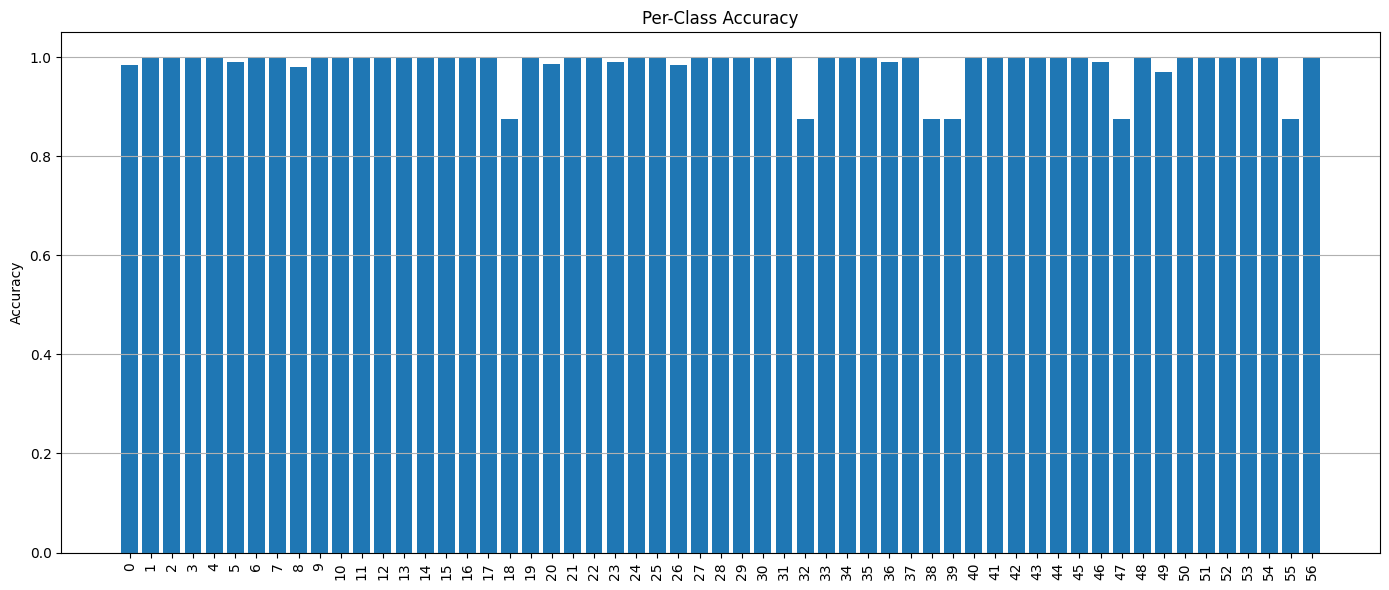

0                   : 98.50%
1                   : 100.00%
2                   : 100.00%
3                   : 100.00%
4                   : 100.00%
5                   : 98.94%
6                   : 100.00%
7                   : 100.00%
8                   : 98.00%
9                   : 100.00%
10                  : 100.00%
11                  : 100.00%
12                  : 100.00%
13                  : 100.00%
14                  : 100.00%
15                  : 100.00%
16                  : 100.00%
17                  : 100.00%
18                  : 87.50%
19                  : 100.00%
20                  : 98.56%
21                  : 100.00%
22                  : 100.00%
23                  : 99.00%
24                  : 100.00%
25                  : 100.00%
26                  : 98.50%
27                  : 100.00%
28                  : 100.00%
29                  : 100.00%
30                  : 100.00%
31                  : 100.00%
32                  : 87.50%
33                

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_per_class_accuracy(y_true, y_pred, label_encoder):
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(label_encoder.classes_)))

    # Compute per-class accuracy
    class_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    class_accuracy = correct_counts / class_counts

    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(label_encoder.classes_)), class_accuracy)
    plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=90)
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Also print
    for i, acc in enumerate(class_accuracy):
        print(f"{label_encoder.classes_[i]:<20}: {acc*100:.2f}%")

# Usage (after all_preds and all_labels are collected)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)  # assumes y_true includes all classes

plot_per_class_accuracy(all_labels, all_preds, label_encoder)


In [ ]:
import pandas as pd


# Load the merged CSV that contains all class info
df = pd.read_csv("final_merged_with_class_ids.csv")

# Check actual column names
print(df.columns.tolist())  # Uncomment this if you’re unsure what the correct column names are

# If the correct columns are "class_id" and "category", modify accordingly:
id_to_class = df[['class_id', 'category']].drop_duplicates().sort_values('class_id').set_index('class_id')['category'].to_dict()

# List of class IDs to lookup 
class_ids = [1, 9, 17, 24, 33, 55, 56]

# Output class names
for cid in class_ids:
    print(f"{cid}: {id_to_class[cid]}")


['path', 'category', 'source', 'class_id']
1: airplane
9: chirping_birds
17: crickets
24: drinking_sipping
33: helicopter
55: water_drops
56: wind


In [49]:
import librosa
import torch
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YAMNet1DCNN_Improved().to(device)
model.load_state_dict(torch.load("Best_Model.pt", map_location=device))
model.eval()

MAX_FRAMES = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load YAMNet from TF Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Class map from your training data
import pandas as pd
df = pd.read_csv("final_merged_with_class_ids.csv")
label_dict = df[['class_id', 'category']].drop_duplicates().set_index('class_id')['category'].to_dict()

# Inference function
def predict_my_class(wav_path):
    try:
        waveform, sr = librosa.load(wav_path, sr=16000, mono=True)
        waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
        _, embeddings, _ = yamnet_model(waveform)
        emb_np = embeddings.numpy()

        MAX_FRAMES = 100
        if emb_np.shape[0] < MAX_FRAMES:
            pad = MAX_FRAMES - emb_np.shape[0]
            emb_np = np.pad(emb_np, ((0, pad), (0, 0)), mode='constant')
        else:
            emb_np = emb_np[:MAX_FRAMES, :]

        input_tensor = torch.tensor(emb_np, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, 100, 1024)
        with torch.no_grad():
            logits = model(input_tensor)
            pred_class = logits.argmax(1).item()
            return label_dict.get(pred_class, f"Class ID: {pred_class}")
    except Exception as e:
        return f"❌ Error: {e}"


In [85]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import librosa

# Settings
DURATION = 20  # seconds
SAMPLE_RATE = 16000
WAV_FILENAME = "recorded.wav"

# Step 1: Record
print("🔴 Recording... Speak clearly into your microphone.")
audio = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
audio = np.squeeze(audio)

# Step 2: Normalize volume
max_val = np.max(np.abs(audio))
if max_val > 0:
    audio = audio / max_val

# Step 3: Save to WAV
sf.write(WAV_FILENAME, audio, SAMPLE_RATE)
print("✅ Recording saved to", WAV_FILENAME)

# Step 4: Predict
result = predict_my_class(WAV_FILENAME)
print("🎯 Predicted Label:", result)


🔴 Recording... Speak clearly into your microphone.
✅ Recording saved to recorded.wav
🎯 Predicted Label: children_playing


In [ ]:
print(predict_my_class("DOG10.wav"))
print(predict_my_class("dog-barking.wav"))
print(predict_my_class("Free-birds-chirping-sound-effect.wav"))
print(predict_my_class("Chirping-birds2.wav"))

dog
dog
chirping_birds


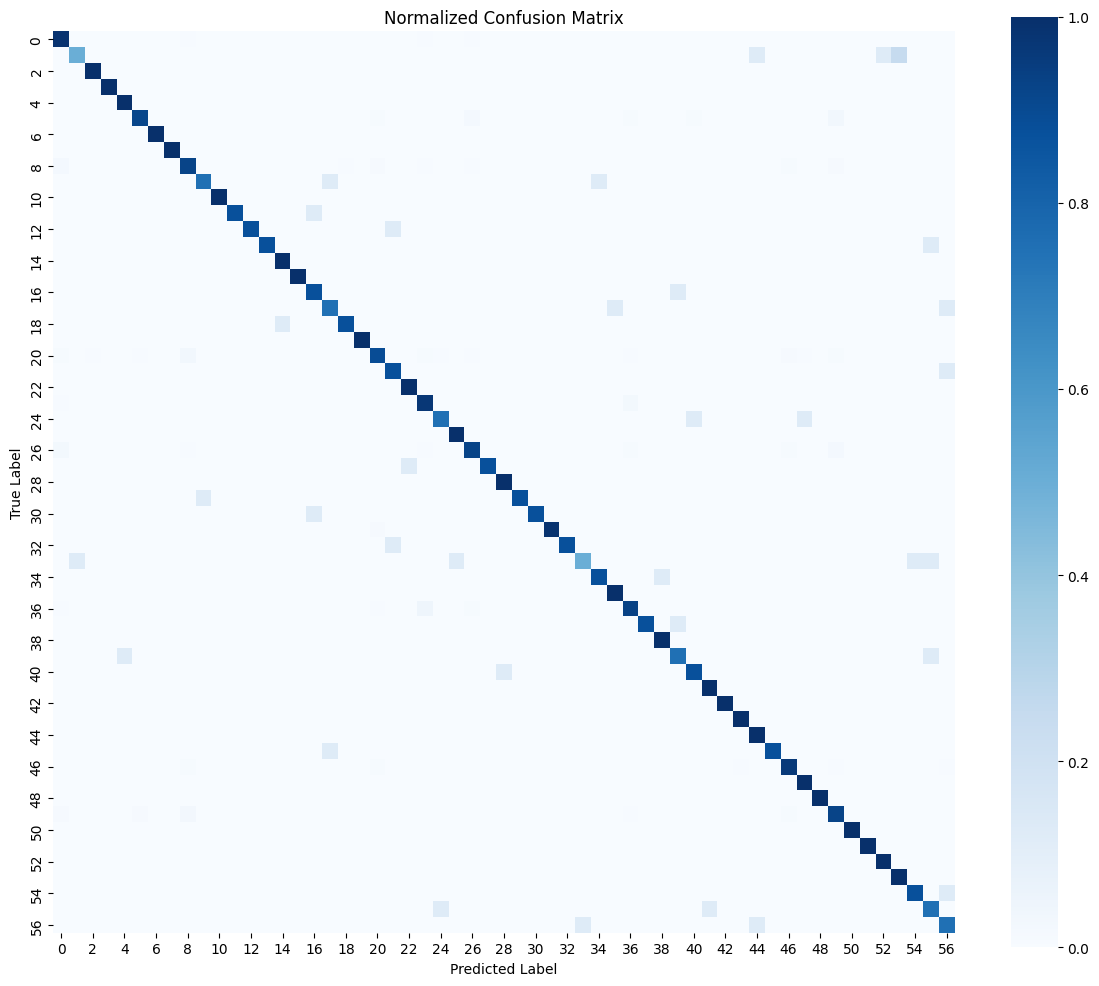

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, cmap='Blues', square=True, cbar=True)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [3]:
%pip install pydub

Note: you may need to restart the kernel to use updated packages.
